In [11]:
import torch
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from sklearn.preprocessing import StandardScaler
import networkx as nx
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils.convert import from_networkx
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
class GCN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_size, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.lin(x)
        return x


def visibility_graph(data, value, window_size=30, step_size=1, batch_size=7):
    frames = []
    vis_frames = []
    targets = []
    values = data.values
    vis_col = data[value].tolist()
    l = len(data)

    for i in range(0, l, step_size):
        end = i + window_size
        if end > l:
            frames.append(values[l - window_size - 1 : l - 1])
            targets.append(values[l - 1])
            vis_frames.append(vis_col[l - window_size - 1 : l - 1])
            break

        frames.append(values[i:end])
        vis_frames.append(vis_col[i:end])
        targets.append(values[end])

    ll = len(frames)
    graphs = []
    for i in range(ll):
        frame = frames[i]
        vis = vis_frames[i]
        target = targets[i]
        G = nx.visibility_graph(vis)
        temp = from_networkx(G)
        edge_index = temp.edge_index
        x = torch.tensor(frame, dtype=torch.float)
        y = torch.tensor(target, dtype=torch.float)
        graph = Data(x=x, edge_index=edge_index, y=y)
        graphs.append(graph)

    return graphs

In [13]:
df = pd.read_csv("../data/test.csv")
cols = df.columns
scaler = StandardScaler()
data = scaler.fit_transform(df)
df = pd.DataFrame(data, columns=cols)

test_graphs = visibility_graph(data=df, value="open", window_size=30, step_size=20)

model = GCN(7, 64 , 7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('gcn.pth', map_location=device, weights_only=True))
model = model.to(device)

In [14]:
model.eval()
predictions = []
ground_truth = []
for batch in test_graphs:
    batch = batch.to(device)
    with torch.no_grad():
        output = model(batch.x, batch.edge_index, batch.batch)
        output = output.view(-1)
        predictions.append(output.cpu().numpy())
        ground_truth.append(batch.y.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
ground_truth = np.concatenate(ground_truth, axis=0)

In [15]:
predictions = predictions.reshape(-1, 7)
ground_truth = ground_truth.reshape(-1, 7)

predictions = scaler.inverse_transform(predictions)
ground_truth = scaler.inverse_transform(ground_truth)
temp = pd.read_csv("../data/temp.csv")
predictions = pd.DataFrame(predictions, columns=cols)
ground_truth = pd.DataFrame(ground_truth, columns=cols)
predictions['published_date'] = temp['published_date']
ground_truth['published_date'] = temp['published_date']

In [16]:
predictions

,open,high,low,close,per_change,traded_quantity,traded_amount,published_date
0,598.047180,602.460815,588.835083,592.787231,0.126216,49900.136719,29285460.0,8/14/2023
1,590.482666,594.962769,581.393127,585.818970,0.080121,48348.781250,27831400.0,8/15/2023
2,548.940247,553.463135,540.393799,545.328430,0.409447,47683.527344,23139904.0,8/16/2023
3,508.006409,511.652985,501.763489,506.368103,0.812728,98911.250000,58386756.0,8/17/2023
4,485.660583,487.691498,482.382111,483.280670,0.626655,93318.875000,52442496.0,8/20/2023
5,456.069061,459.368591,450.232635,454.277771,-0.054861,53403.785156,24903978.0,8/21/2023
6,453.401306,454.824188,443.463074,448.845734,-0.629828,50046.824219,20257440.0,8/22/2023
7,440.649445,439.258545,430.470123,433.165344,-0.488384,55541.917969,23401870.0,8/23/2023
8,473.662201,478.244476,463.608917,468.911041,0.178936,104865.945312,47522352.0,8/24/2023
9,490.448669,492.052826,479.982910,483.969604,-0.493047,72299.390625,36104300.0,8/27/2023


In [17]:
ground_truth

,open,high,low,close,per_change,traded_quantity,traded_amount,published_date
0,583.000000,588.400024,579.500000,583.000000,-3.400000e-01,44667.000000,26055976.0,8/14/2023
1,577.799988,577.799988,567.000000,569.900024,3.300000e-01,32456.001953,18470134.0,8/15/2023
2,539.000000,539.000000,520.000000,522.000000,-1.230000e+00,71048.000000,37397216.0,8/16/2023
3,499.000000,499.899994,490.000000,493.000000,2.000000e-01,52810.000000,26080336.0,8/17/2023
4,486.000000,486.000000,474.500000,475.000000,-3.100000e-01,87081.000000,41536812.0,8/20/2023
5,458.699982,470.000000,455.000000,469.000000,4.270000e+00,62909.000000,29076698.0,8/21/2023
6,438.000000,446.000000,436.600006,438.000000,1.127139e-09,37958.000000,16656744.0,8/22/2023
7,440.000000,441.000000,434.000000,434.000000,1.200000e-01,36943.000000,16131722.0,8/23/2023
8,488.600006,488.600006,473.200012,475.000000,-8.600000e-01,48170.000000,22914154.0,8/24/2023
9,539.500000,545.000000,521.000000,524.000000,-9.500000e-01,157693.000000,83658136.0,8/27/2023


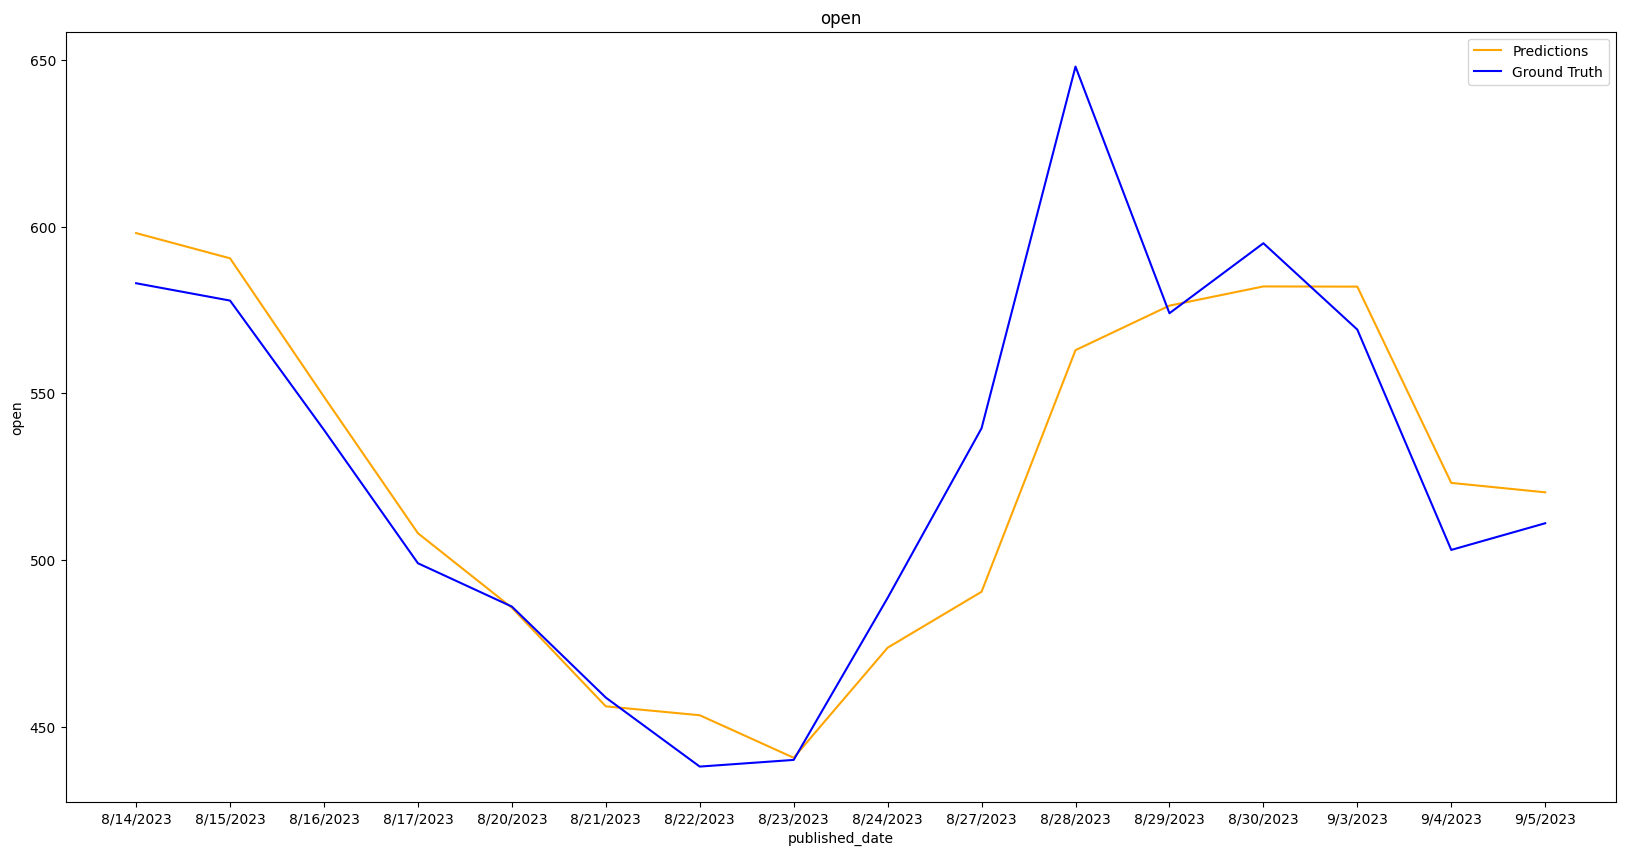

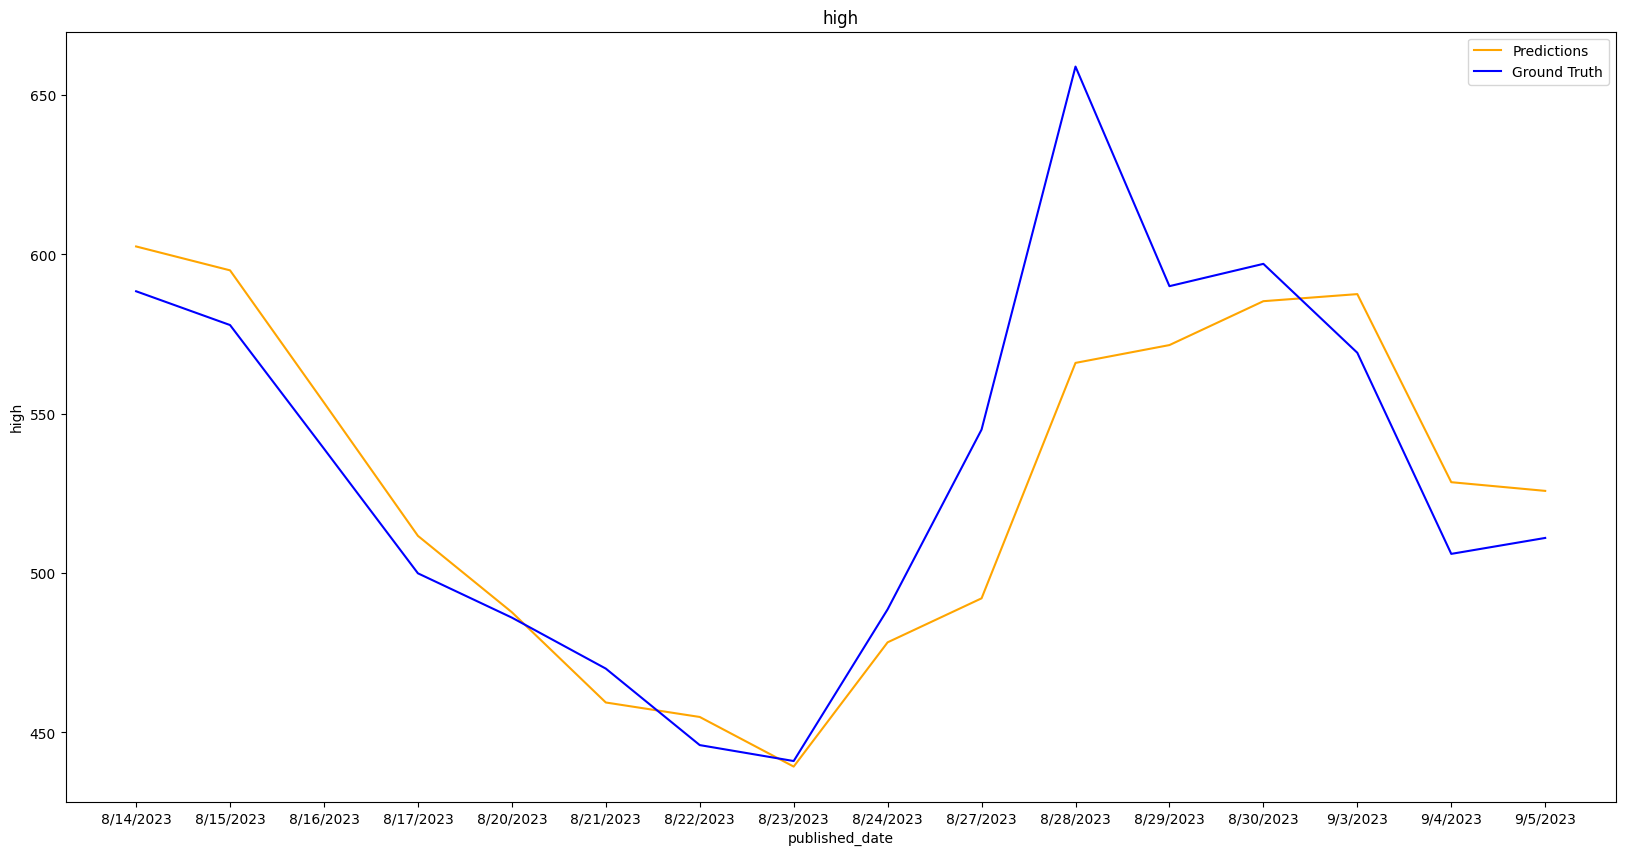

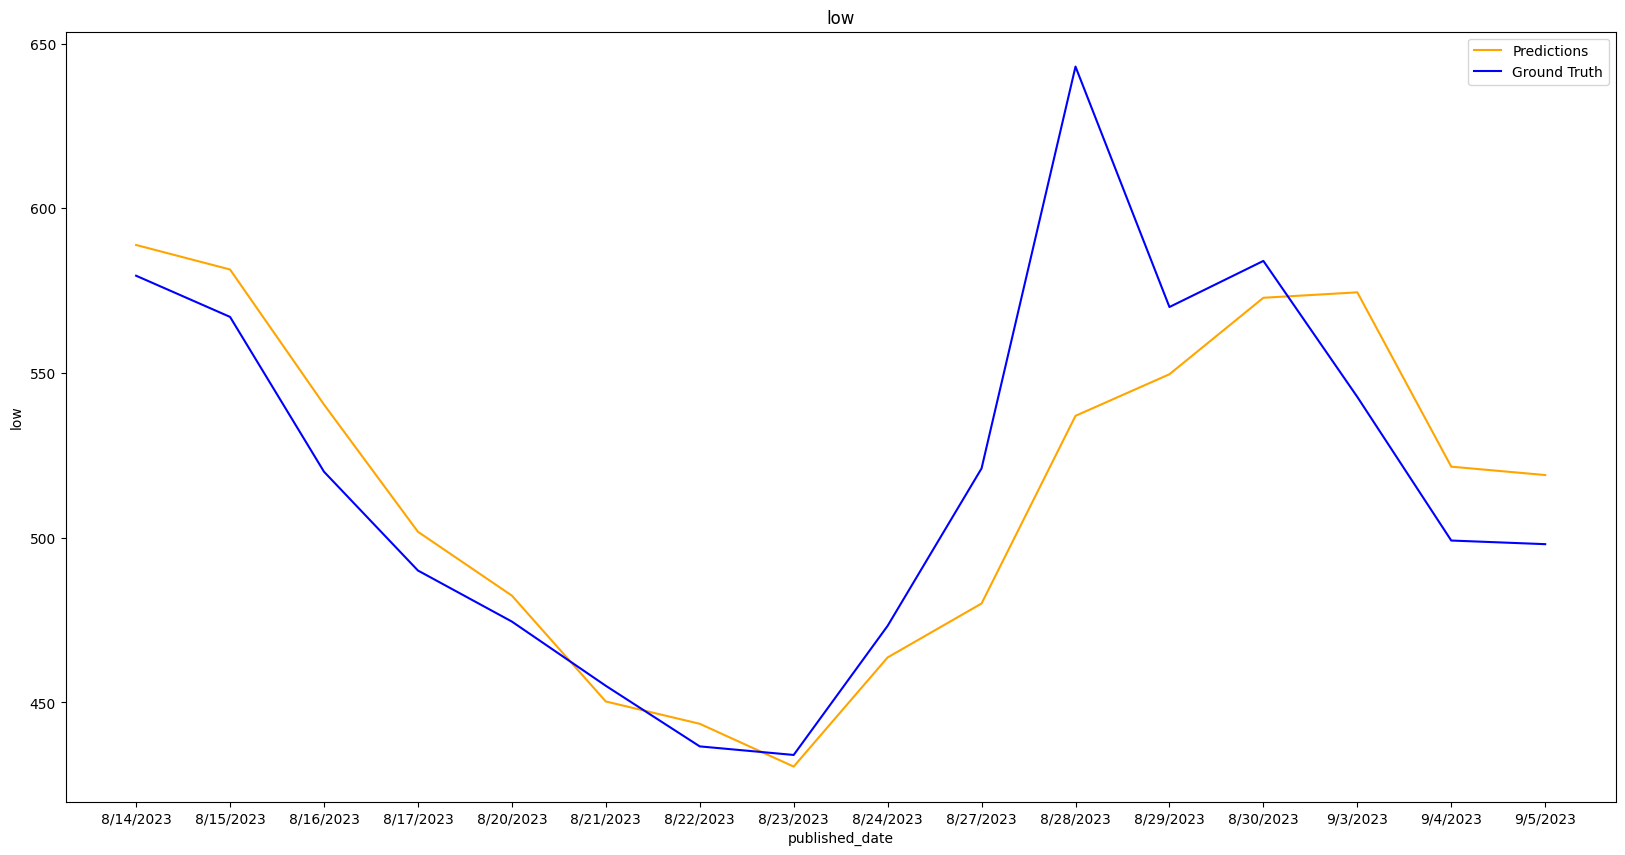

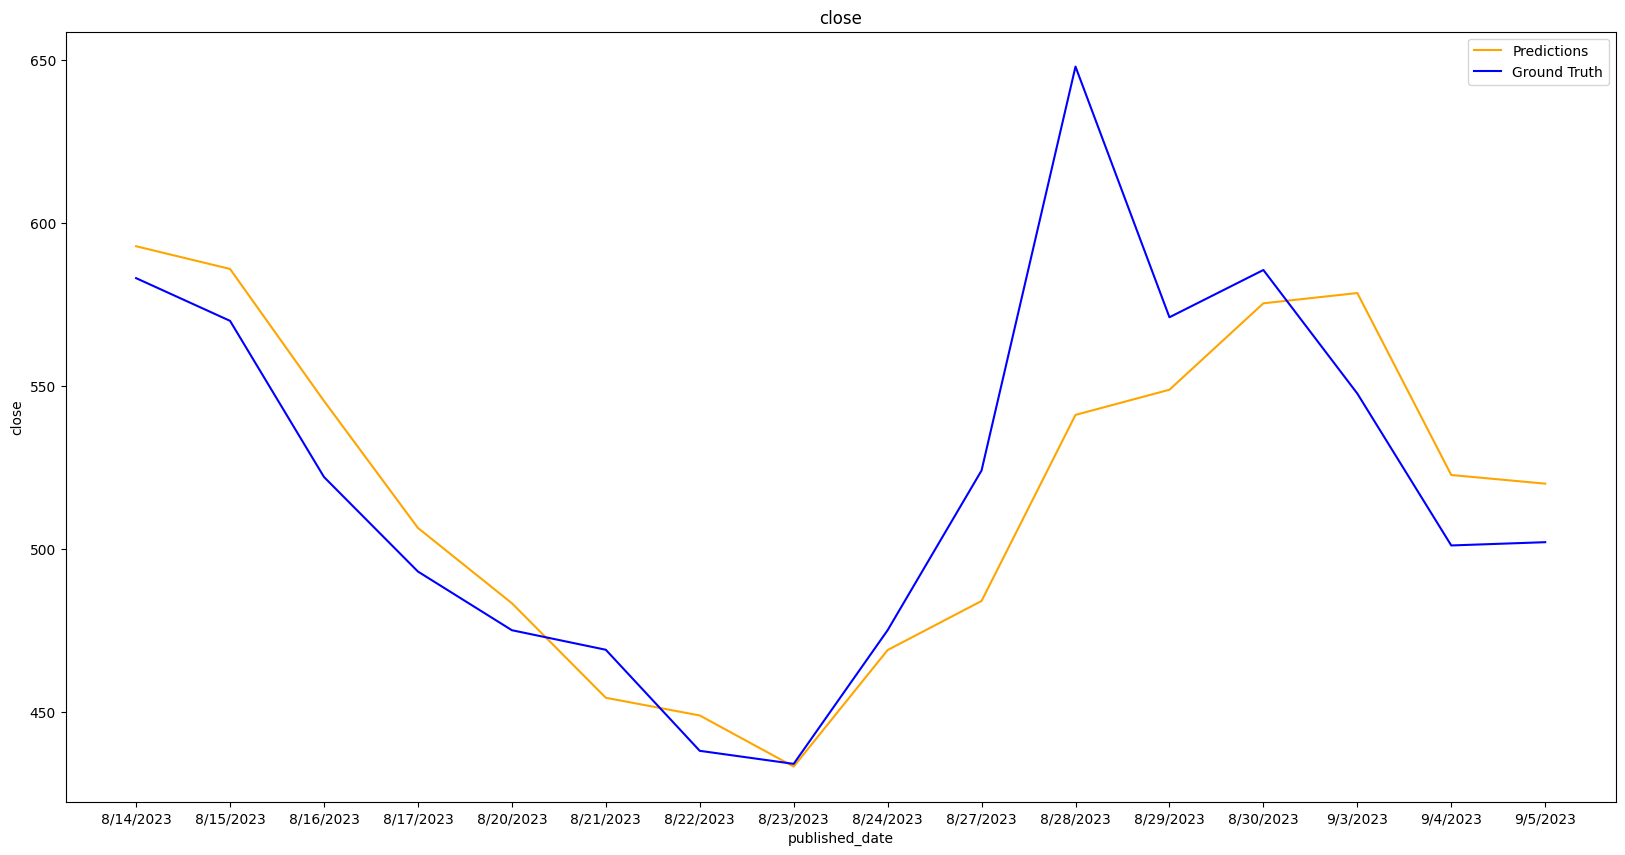

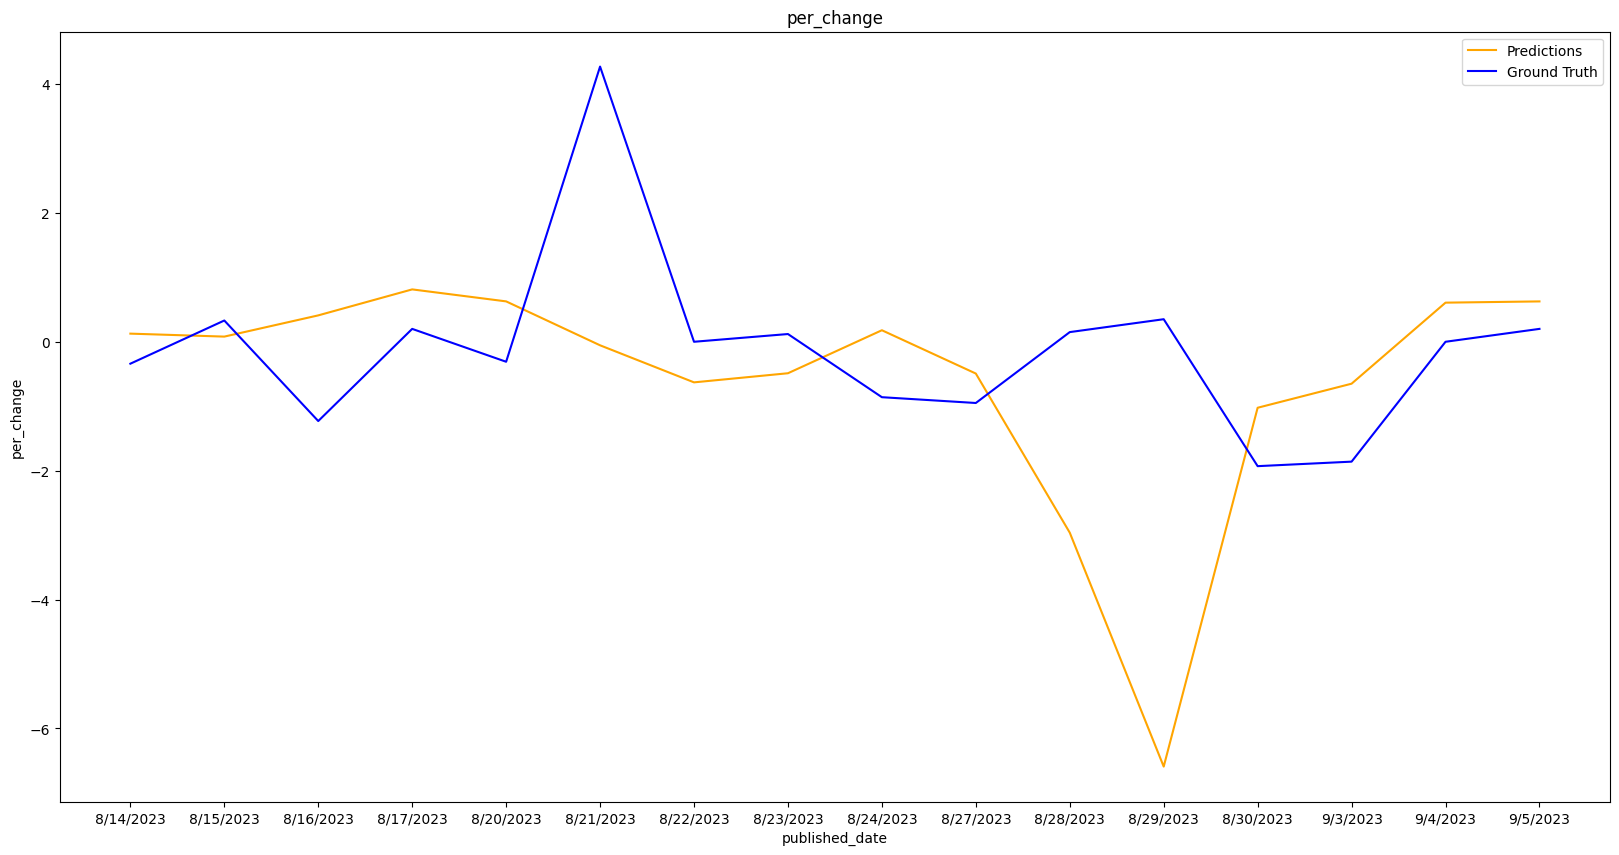

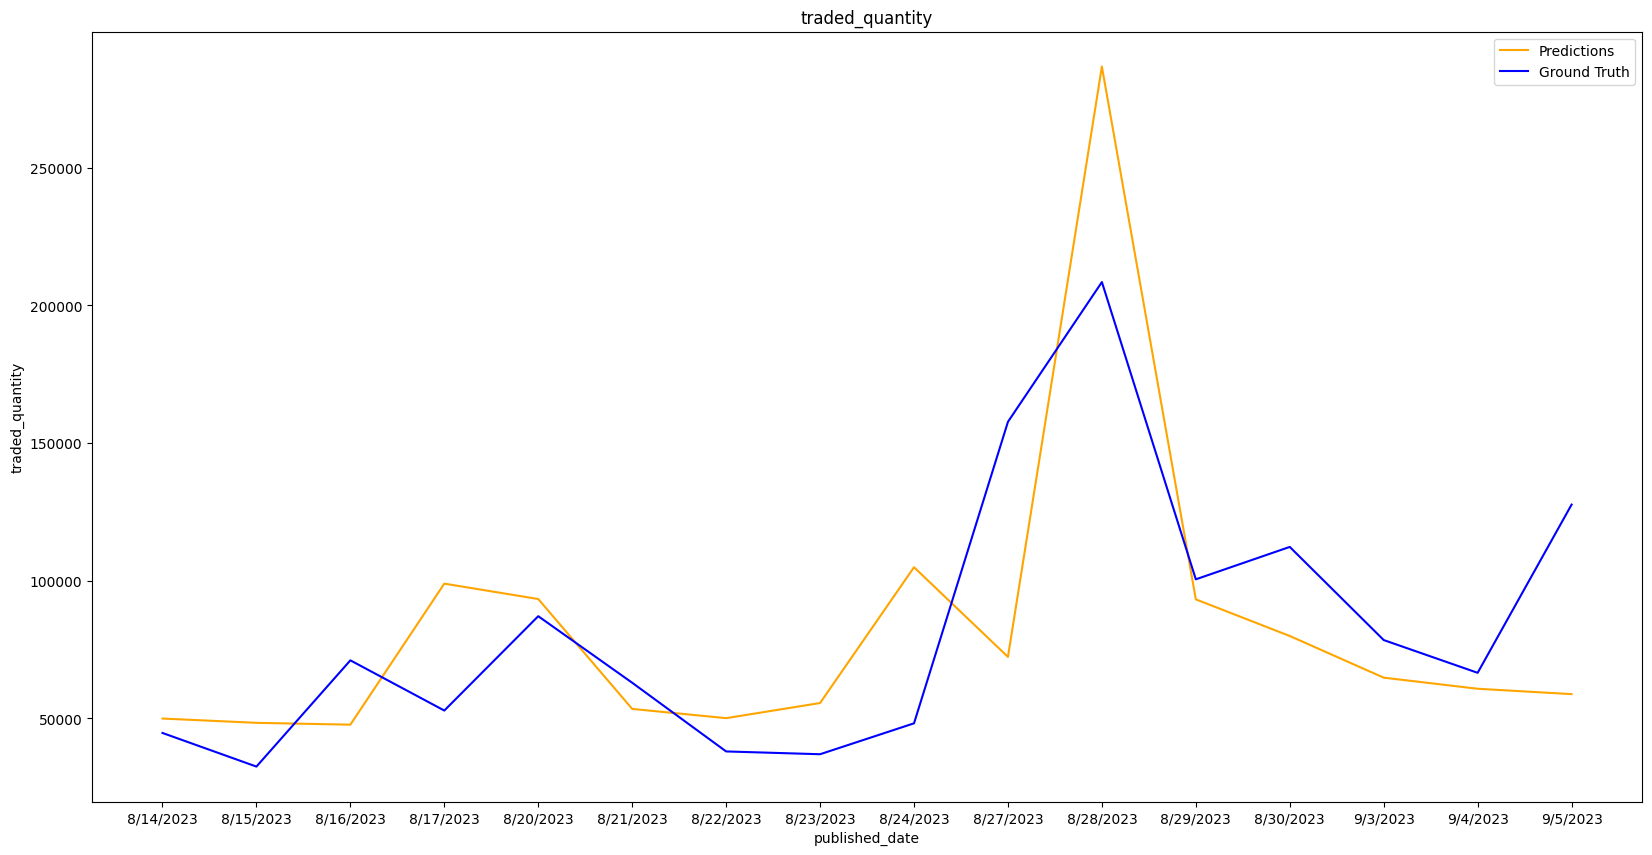

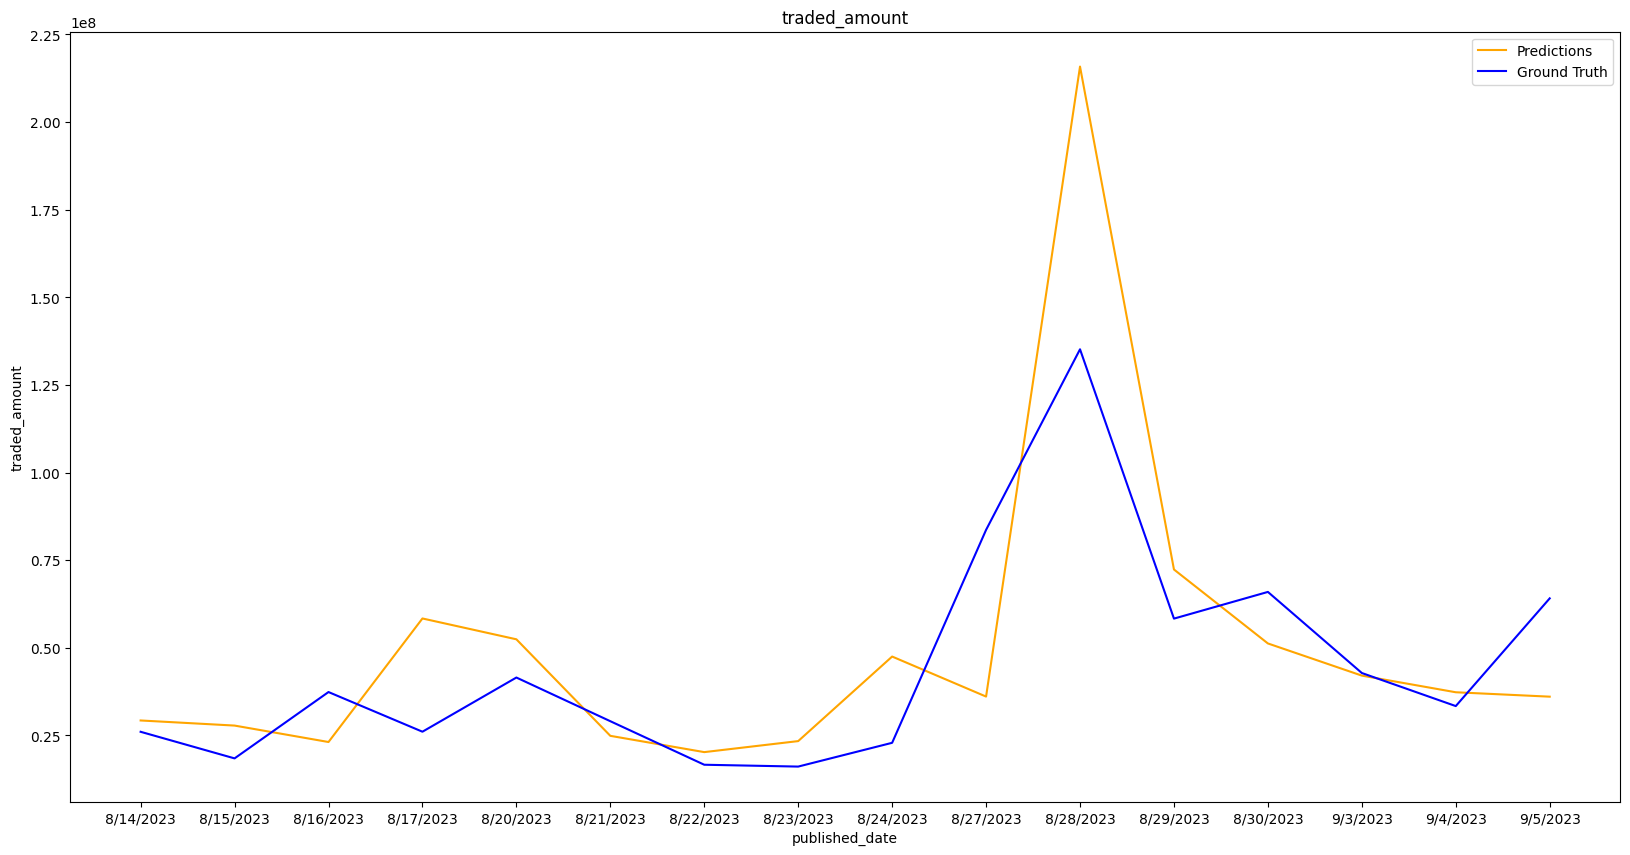

In [20]:
for col in cols:
    plt.figure(figsize=(20,10))
    sns.lineplot(predictions, x='published_date', y=col, color="orange", label="Predictions")
    sns.lineplot(ground_truth, x='published_date', y=col, color="blue", label="Ground Truth")
    plt.title(f"{col}")
    plt.show()